# Geometrical Data Analysis : implementation of some key elements

# Link between eigenvalues and frequencies in Fourier

/var/folders/2x/0bkc7scj72s686g1k6vs77x00000gn/T/ipykernel_3339/2286182967.py:21: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.14.0. Use `.toarray()` instead.
  eigenvalues, eigenvectors = np.linalg.eigh(L.A)


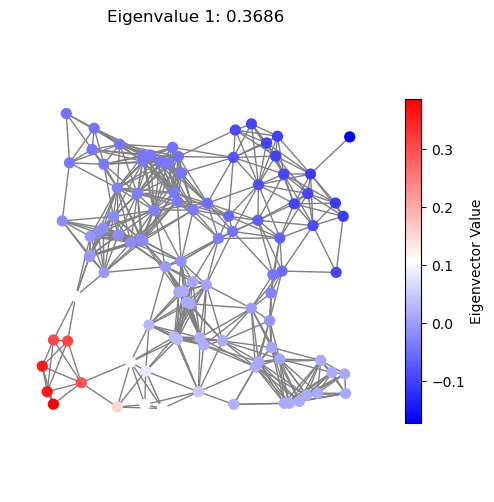

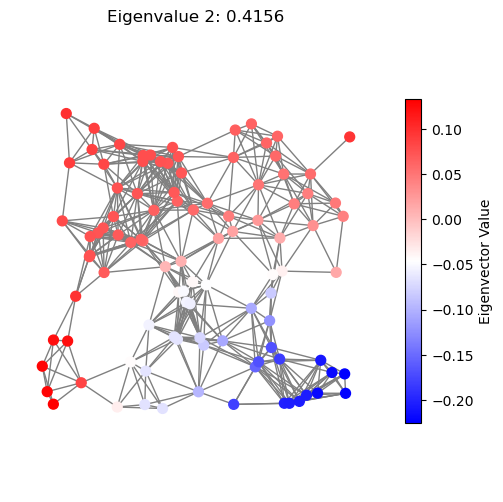

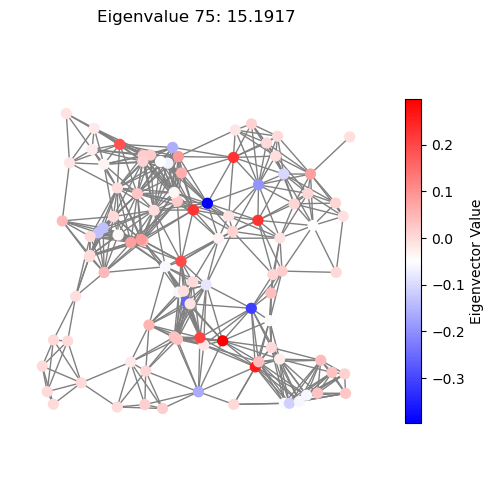

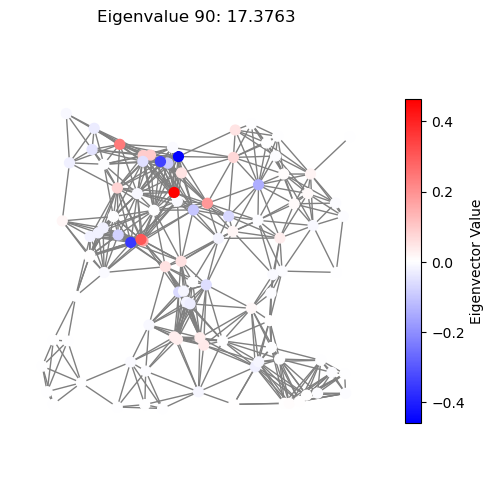

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


n = 100 
radius = 0.2  
G = nx.random_geometric_graph(n, radius)

if not nx.is_connected(G):
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()

pos = nx.get_node_attributes(G, 'pos')

G = nx.convert_node_labels_to_integers(G)
pos = {i: pos[node] for i, node in enumerate(G.nodes())}

L = nx.laplacian_matrix(G).astype(float)

eigenvalues, eigenvectors = np.linalg.eigh(L.A)

def plot_eigenvector(G, eigenvector, pos, title):
    fig, ax = plt.subplots(figsize=(6, 6))
    node_values = eigenvector
    vmin = np.min(node_values)
    vmax = np.max(node_values)
    cmap = plt.cm.bwr 
    
    nodes = nx.draw_networkx_nodes(
        G,
        pos,
        node_color=node_values,
        cmap=cmap,
        node_size=50,
        vmin=vmin,
        vmax=vmax,
        ax=ax,
    )
    
    nx.draw_networkx_edges(G, pos, edge_color='gray', ax=ax)
    
    ax.set_title(title)
    
    cbar = plt.colorbar(nodes, ax=ax, shrink=0.7)
    cbar.ax.set_ylabel('Eigenvector Value')
    
    ax.axis('equal')
    ax.axis('off')  
    plt.show()

eigen_indices = [1, 2, 75, 90]  

for idx in eigen_indices:
    if idx >= len(eigenvalues):
        continue 
    eigenvector = eigenvectors[:, idx]
    eigenvalue = eigenvalues[idx]
    title = f"Eigenvalue {idx}: {eigenvalue:.4f}"
    plot_eigenvector(G, eigenvector, pos, title)


# Convolution of a dirac using polynomials of Laplacian

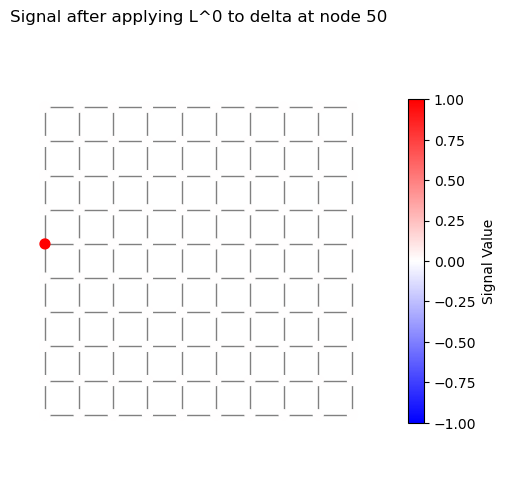

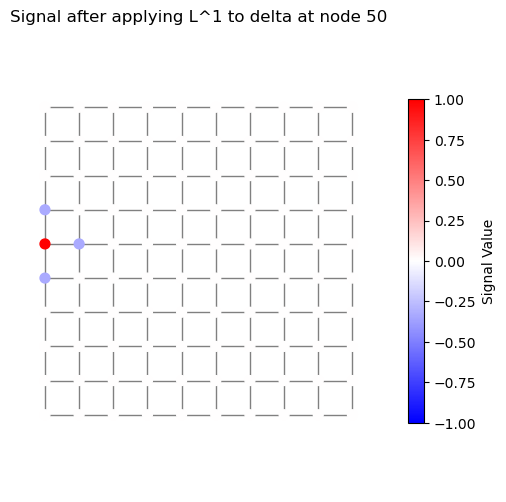

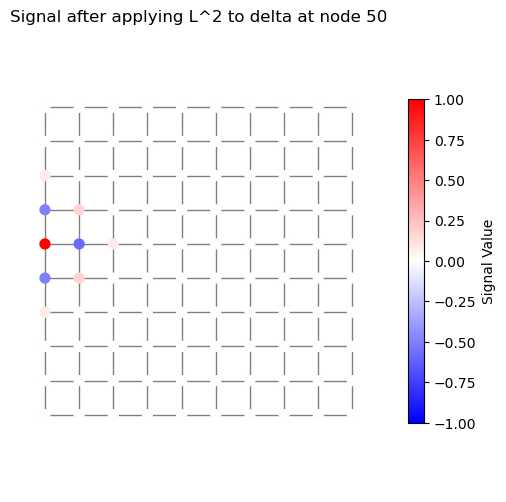

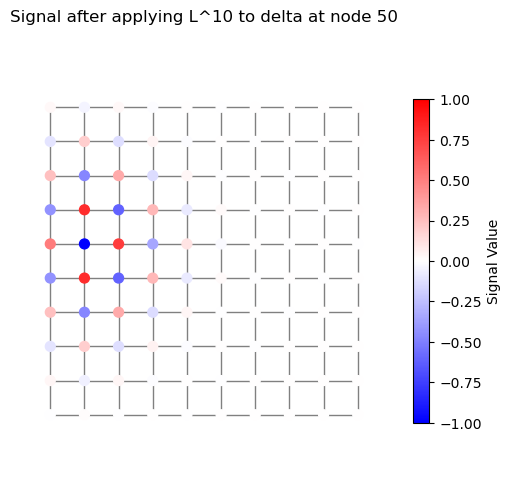

In [5]:
n = 10 
G = nx.grid_2d_graph(n, n)
G = nx.convert_node_labels_to_integers(G)

L = nx.laplacian_matrix(G).astype(float).todense()

pos = {i: (i % n, i // n) for i in G.nodes()}

def plot_signal(G, signal, pos, title):
    fig, ax = plt.subplots(figsize=(6, 6))
    node_values = np.array(signal).flatten()
    
    max_abs = np.max(np.abs(node_values))
    
    cmap = plt.cm.bwr 
    vmin = -max_abs
    vmax = max_abs

    nodes = nx.draw_networkx_nodes(
        G,
        pos,
        node_color=node_values,
        cmap=cmap,
        node_size=50,
        vmin=vmin,
        vmax=vmax,
        ax=ax,
    )
    nx.draw_networkx_edges(G, pos, edge_color='gray', ax=ax)

    ax.set_title(title)
    cbar = plt.colorbar(nodes, ax=ax, shrink=0.7)
    cbar.ax.set_ylabel('Signal Value')
    ax.axis('equal')
    ax.axis('off')
    plt.show()

initial_node = n * n // 2  
delta = np.zeros((n * n, 1))
delta[initial_node] = 1 

k_values = [0, 1, 2, 10]

for k in k_values:
    Lk = np.linalg.matrix_power(L, k)
    
    signal = Lk @ delta
    
    signal_normalized = signal / np.max(np.abs(signal))
    
    title = f"Signal after applying L^{k} to delta at node {initial_node}"
    plot_signal(G, signal_normalized, pos, title)


# Illustration of graph coarsening

Original Graph: 22 nodes, 26 edges
Level 1: 13 nodes


/var/folders/2x/0bkc7scj72s686g1k6vs77x00000gn/T/ipykernel_3339/2923000570.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_list = plt.cm.get_cmap('tab20', num_colors).colors


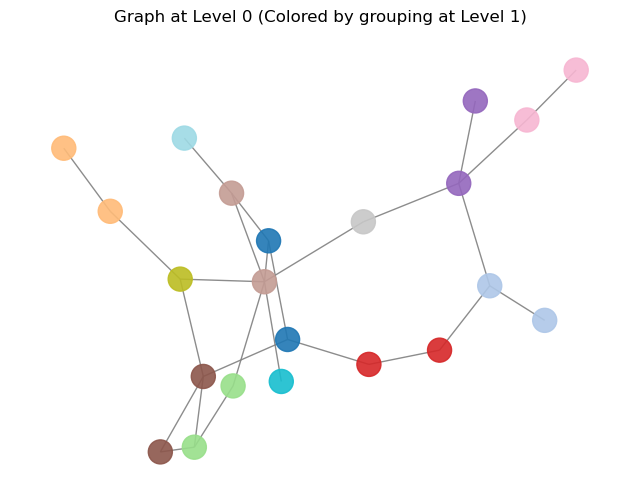

Level 2: 8 nodes


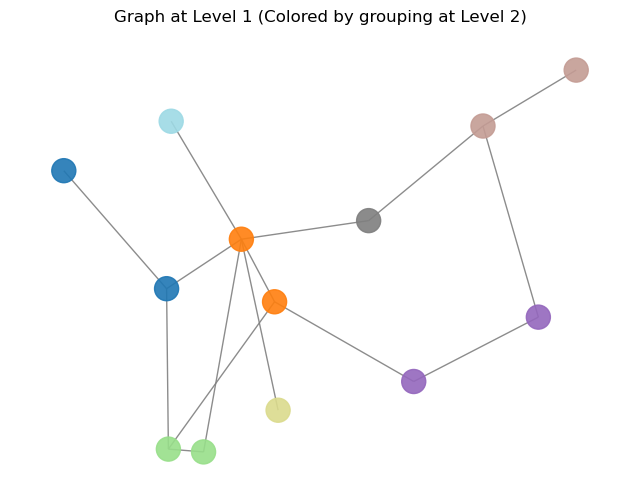

Level 3: 5 nodes


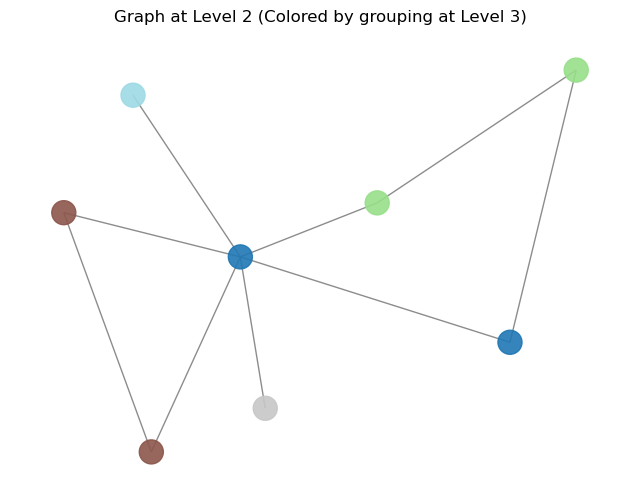

Level 4: 4 nodes


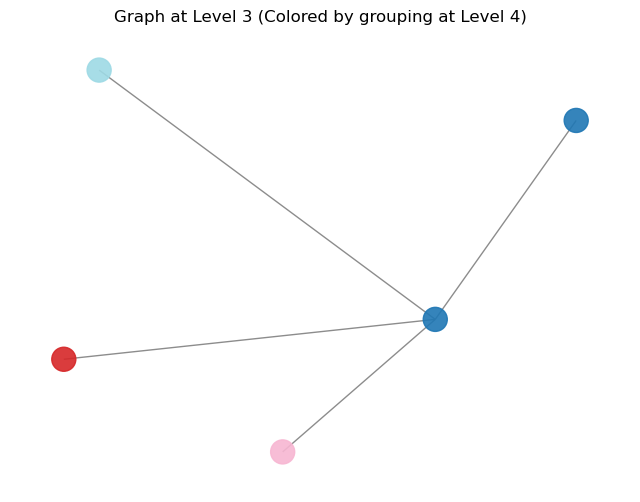

In [6]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def generate_random_graph(n_nodes, p_edge):
    G = nx.erdos_renyi_graph(n_nodes, p_edge)
    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()
    return G

def maximal_matching_coarsening(G):
    matching_edges = nx.maximal_matching(G)
    matched_nodes = set()
    mapping = {}
    new_node_id = 0
    for u, v in matching_edges:
        mapping[u] = new_node_id
        mapping[v] = new_node_id
        matched_nodes.update([u, v])
        new_node_id += 1
    for n in G.nodes():
        if n not in matched_nodes:
            mapping[n] = new_node_id
            new_node_id += 1
    G_coarse = nx.Graph()
    for n in G.nodes():
        new_n = mapping[n]
        if new_n not in G_coarse:
            G_coarse.add_node(new_n, size=1)
        else:
            G_coarse.nodes[new_n]['size'] += 1
    for u, v in G.edges():
        new_u = mapping[u]
        new_v = mapping[v]
        if new_u != new_v:
            if G_coarse.has_edge(new_u, new_v):
                G_coarse[new_u][new_v]['weight'] += 1
            else:
                G_coarse.add_edge(new_u, new_v, weight=1)
    return G_coarse, mapping

def compute_coarse_positions(G_prev, mapping, pos_prev):
    G_coarse_nodes = set(mapping.values())
    pos_coarse = {}
    for supernode in G_coarse_nodes:
        nodes_in_supernode = [n for n in G_prev.nodes() if mapping[n] == supernode]
        x_coords = [pos_prev[n][0] for n in nodes_in_supernode]
        y_coords = [pos_prev[n][1] for n in nodes_in_supernode]
        pos_coarse[supernode] = (np.mean(x_coords), np.mean(y_coords))
    return pos_coarse

def plot_graph(G, title, pos, node_colors=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    sizes = [G.nodes[n].get('size', 1) * 100 for n in G.nodes()]
    
    if node_colors is None:
        node_color_values = sizes
        cmap = plt.cm.viridis
        norm = mcolors.Normalize(vmin=min(node_color_values), vmax=max(node_color_values))
        nx.draw(
            G,
            pos,
            with_labels=False,
            node_size=sizes,
            node_color=node_color_values,
            cmap=cmap,
            edge_color='gray',
            alpha=0.9,
            ax=ax,
        )
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
        cbar.ax.set_ylabel('Supernode Size (Number of Merged Nodes)')
    else:
        node_color_values = [node_colors[n] for n in G.nodes()]
        unique_groups = list(set(node_color_values))
        num_colors = len(unique_groups)
        color_list = plt.cm.get_cmap('tab20', num_colors).colors
        if num_colors > len(color_list):
            color_list = plt.cm.get_cmap('hsv', num_colors).colors
        color_dict = {group: color_list[i % num_colors] for i, group in enumerate(unique_groups)}
        node_colors_mapped = [color_dict[node_colors[n]] for n in G.nodes()]
        nx.draw(
            G,
            pos,
            with_labels=False,
            node_color=node_colors_mapped,
            edge_color='gray',
            alpha=0.9,
            ax=ax,
        )
    ax.set_title(title)
    ax.axis('off')
    plt.show()
    return pos

def multilevel_coarsening(G, levels):
    graphs = [G]
    mappings = []
    positions = []
    pos = nx.spring_layout(G, seed=42)
    positions.append(pos)
    for level in range(levels):
        G_coarse, mapping = maximal_matching_coarsening(graphs[-1])
        graphs.append(G_coarse)
        mappings.append(mapping)
        print(f"Level {level+1}: {G_coarse.number_of_nodes()} nodes")
        node_colors = mapping
        title = f'Graph at Level {level} (Colored by grouping at Level {level+1})'
        plot_graph(graphs[level], title, positions[level], node_colors)
        pos_coarse = compute_coarse_positions(graphs[level], mapping, positions[level])
        positions.append(pos_coarse)
    return graphs

n_nodes = 30
p_edge = 0.05
coarsening_levels = 4

G = generate_random_graph(n_nodes, p_edge)
print(f"Original Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

graphs = multilevel_coarsening(G, coarsening_levels)


# Training on the Cora Dataset

In [7]:
import torch
from torch_geometric.nn import ChebConv, max_pool
from torch_geometric.nn.pool import graclus
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
from torch_geometric.data import Data

dataset = Planetoid(root='.', name='Cora')

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, K):
        super().__init__()
        # Graph convolution layers
        self.conv1 = ChebConv(in_channels, hidden_channels, K)
        #self.conv2 = ChebConv(hidden_channels, hidden_channels, K)
        #self.conv3 = ChebConv(hidden_channels, hidden_channels, K)
        
        # Fully connected layer for classification
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch=None):
        # First Chebyshev convolution + ReLU
        num_nodes = x.size(0)
        x = self.conv1(x, edge_index).relu()

        data_tmp = Data(x=x, edge_index=edge_index, batch=batch)
        
        # Graph coarsening using Graclus and pooling
        cluster1 = graclus(edge_index)  # Create clusters for coarsening
        
        cluster1_to_node_mapping = {}
        for left, right in enumerate(cluster1.numpy()):
            if right not in cluster1_to_node_mapping:
                cluster1_to_node_mapping[right] = []
            cluster1_to_node_mapping[right].append(left)
        sorted_keys = sorted(cluster1_to_node_mapping.keys())
        
        ordered_dict = {}
        for new_key, old_key in enumerate(sorted_keys):
            ordered_dict[new_key] = cluster1_to_node_mapping[old_key]
        cluster1_to_node_mapping = ordered_dict
        
        data_tmp = max_pool(cluster1, data_tmp)
        
        x, edge_index, batch = data_tmp.x, data_tmp.edge_index, data_tmp.batch
        """x = self.conv2(x, edge_index).relu()
        
        data_tmp = Data(x=x, edge_index=edge_index, batch=batch)
        
        # Step 4: Graph coarsening again using Graclus and pooling
        cluster2 = graclus(data_tmp.edge_index)  # Coarsen the graph further
        data_tmp = max_pool(cluster2, data_tmp)
        
        cluster2_to_cluster1_mapping = {}
        for left, right in enumerate(cluster2.numpy()):
            if right not in cluster2_to_cluster1_mapping:
                cluster2_to_cluster1_mapping[right] = []
            cluster2_to_cluster1_mapping[right].append(left)
        
        sorted_keys = sorted(cluster2_to_cluster1_mapping.keys())
        
        ordered_dict = {}
        for new_key, old_key in enumerate(sorted_keys):
            ordered_dict[new_key] = cluster2_to_cluster1_mapping[old_key]
        cluster2_to_cluster1_mapping = ordered_dict
        
        final_cluster_to_node_mapping = {}
        for cluster2_id, cluster1_ids in cluster2_to_cluster1_mapping.items():
            nodes = []
            for cluster1_id in cluster1_ids:
                nodes.extend(cluster1_to_node_mapping[cluster1_id])
            final_cluster_to_node_mapping[cluster2_id] = nodes"""

        x, edge_index, batch = data_tmp.x, data_tmp.edge_index, data_tmp.batch
        #x = self.conv3(x, edge_index).relu()

        # Fully connected layer for output
        out = self.fc(x)
        
        node_output = torch.zeros((num_nodes, out.size(1)), device=out.device)
        #for cluster2_id, node_ids in final_cluster_to_node_mapping.items():
        for cluster2_id, node_ids in cluster1_to_node_mapping.items():
            for node_id in node_ids:
                node_output[node_id] = out[cluster2_id]
        
        return node_output


model = GCN(dataset.num_features, 16, dataset.num_classes, 5)

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

# Data
data = dataset[0]  # Cora dataset has only one graph

print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [9]:
# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)  # Forward pass
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])  # Loss on train mask
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights
    return loss.item()

# Test function
def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)  # Forward pass
        pred = out.argmax(dim=1)  # Get class predictions
        accs = []
        for mask in [data.train_mask, data.val_mask, data.test_mask]:
            correct = (pred[mask] == data.y[mask]).sum()
            acc = int(correct) / int(mask.sum())
            accs.append(acc)
        return accs

train_losses = []
val_accuracies = []
test_accuracies = []
train_accuracies = []

# Training loop
for epoch in range(100):  # Train for 100 epochs
    loss = train()
    train_acc, val_acc, test_acc = test()
    
    train_losses.append(loss)
    
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
    
    if epoch % 10 == 0:  # Print progress every 10 epochs
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch 000 | Loss: 1.9665 | Train Acc: 0.5857 | Val Acc: 0.3300 | Test Acc: 0.3390
Epoch 010 | Loss: 0.1305 | Train Acc: 1.0000 | Val Acc: 0.7420 | Test Acc: 0.7520
Epoch 020 | Loss: 0.0146 | Train Acc: 0.9929 | Val Acc: 0.7140 | Test Acc: 0.7200
Epoch 030 | Loss: 0.0018 | Train Acc: 0.9857 | Val Acc: 0.7580 | Test Acc: 0.7490
Epoch 040 | Loss: 0.0295 | Train Acc: 0.9929 | Val Acc: 0.5860 | Test Acc: 0.6000
Epoch 050 | Loss: 0.0026 | Train Acc: 1.0000 | Val Acc: 0.7540 | Test Acc: 0.7770
Epoch 060 | Loss: 0.0234 | Train Acc: 0.9857 | Val Acc: 0.7520 | Test Acc: 0.7670
Epoch 070 | Loss: 0.0075 | Train Acc: 1.0000 | Val Acc: 0.7320 | Test Acc: 0.7340
Epoch 080 | Loss: 0.0185 | Train Acc: 1.0000 | Val Acc: 0.7420 | Test Acc: 0.7530
Epoch 090 | Loss: 0.0168 | Train Acc: 0.9929 | Val Acc: 0.7280 | Test Acc: 0.7480


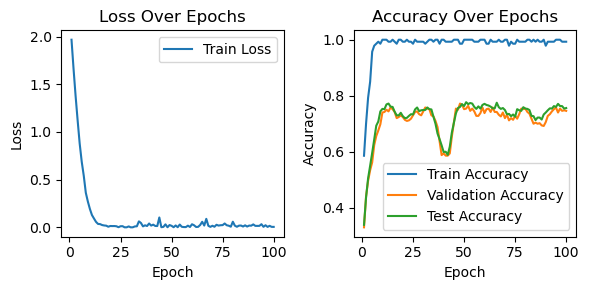

Final Test Accuracy: 0.7540


In [10]:
epochs = range(1, 101)

plt.figure(figsize=(6, 3))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

# Final accuracy
_, _, final_test_acc = test()
print(f"Final Test Accuracy: {final_test_acc:.4f}")